## Simulation for galaxy inclinations and expansions with Fourier-Laguerre pairs
- Manual Expansions
- Finding best coefficients limit
- Identifying relation between coefficients/order and inclination angle and comparing various ratios

## Initialising Galaxy Parameters and Importing Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py
from tqdm import tqdm # progress bar for loops, interrupt if needed
from scipy.optimize import curve_fit

#Formatting for plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file
from src.OriginalDiscModel import DiscGalaxy
N = 1000000 # number of stars in the disc
a = 1.5 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""

'Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes.'

## Manually testing various maximum order

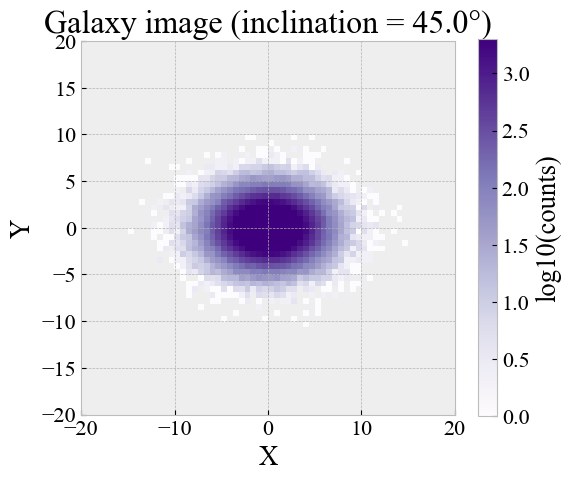

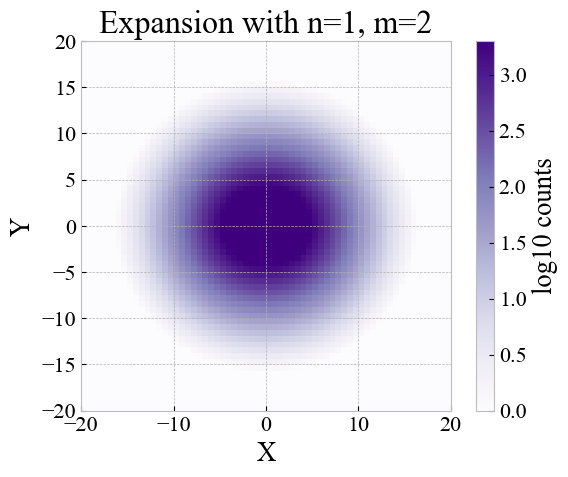

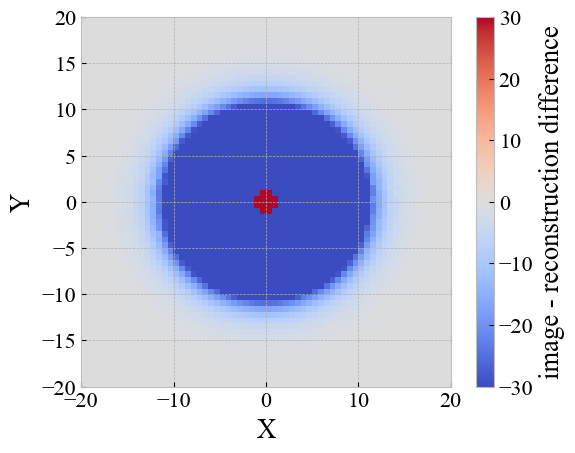

In [2]:

rmax = 20.
nbins = 64
noise = 0.5
inclinationvalue = 45.  # degrees

D = DiscGalaxy(N=1000000, a=1.)  # adjust N and a as needed
D.rotate_disc(inclinationvalue, 0, 0)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)

# --- Prepare safe log image ---
# Replace zero pixels with NaN to avoid log10(-inf) warnings
safe_img = np.where(D.img > 0, D.img, np.nan)
log_img = np.log10(safe_img)

# --- Plot the log-scaled image ---
plt.figure(figsize=(6, 5))
plt.imshow(log_img, origin='lower', cmap='Purples',
           extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10(counts)')
plt.title(f"Galaxy image (inclination = {inclinationvalue}°)")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()


m=2
n=1
#Toggle this to see the expansion coefficients and how they change, goal: find the closest match to the image
E1 = D.make_expansion(m,n,a,noisy=False)

# (re)construct an image from the expansion coefficients
E1.laguerre_reconstruction(D.r,D.p)


plt.imshow(np.log10(E1.reconstruction), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)
plt.colorbar(label='log10 counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Expansion with n={n}, m={m}')
plt.show()

plt.figure()
# why is there a 3%ish bias here?
plt.imshow(D.img - 1.03*E1.reconstruction, origin='lower', cmap='coolwarm', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=-30.,vmax=30.)
plt.colorbar(label='image - reconstruction difference')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()




## Automating the best coefficients

mmax: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s]

Best match: mmax = 3, nmax = 5, NRMSE = 0.01602



/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_29855/2523619100.py:48: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_orig), origin='lower', cmap='Purples',


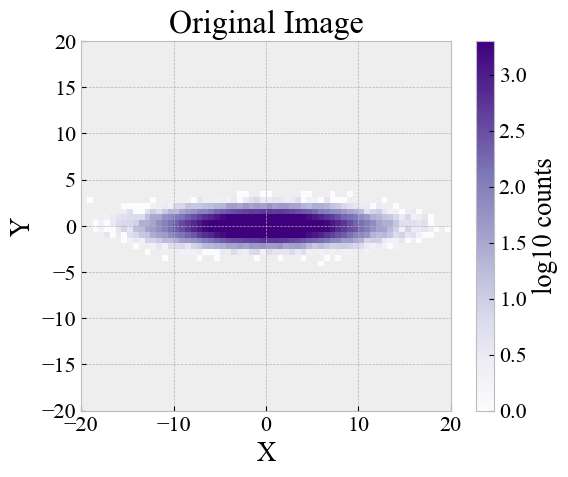

/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_29855/2523619100.py:59: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(best_E.reconstruction), origin='lower', cmap='Purples',


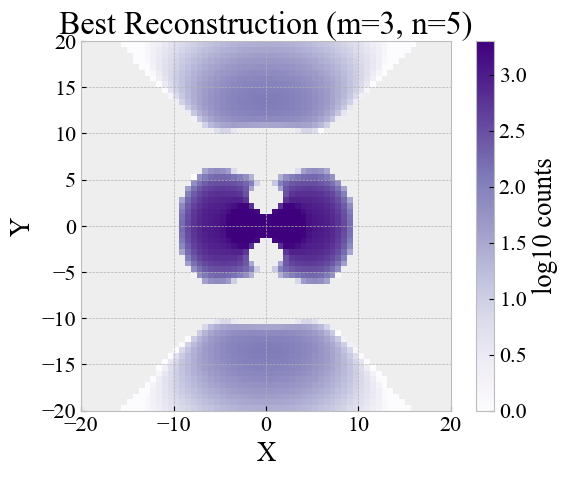

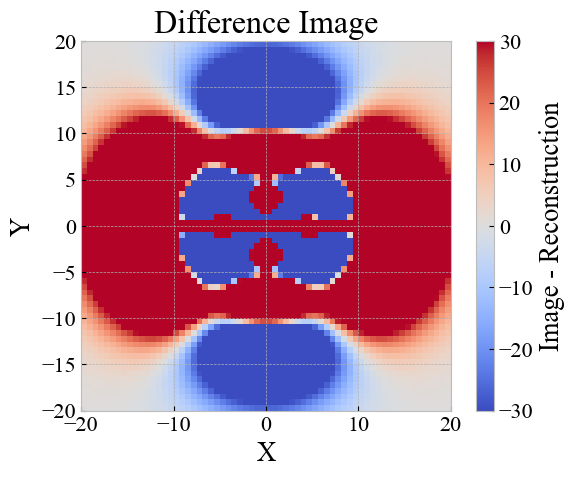

In [3]:
# Simulated Galaxies and Expansions
rmax = 20.
nbins = 64
noise = 0.5
inclinationvalue = 80.

D = DiscGalaxy(N=N, a=a)
D.rotate_disc(inclinationvalue, 0, 0)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)

img_orig = D.img.copy()
x_edges, y_edges = D.x_edges, D.y_edges

#Finding the best expansion coefficients
# We will try different mmax and nmax values to find the best fit to the original
m_values = range(1, 20, 1) #vary m and n ranges to find the best fit
n_values = range(1, 20, 1)
errors = []
best_error = np.inf
best_config = None
best_E = None

for m in tqdm(m_values, desc="mmax"):
    for n in n_values:
        try:
            E = D.make_expansion(m, n, a)
            E.laguerre_reconstruction(D.r, D.p)
            recon = E.reconstruction

            mask = np.isfinite(img_orig) & np.isfinite(recon)
            nrmse = np.sqrt(np.mean((img_orig[mask] - recon[mask])**2)) / np.max(img_orig)

            errors.append((m, n, nrmse))

            if nrmse < best_error:
                best_error = nrmse
                best_config = (m, n)
                best_E = E
        except Exception as e:
            print(f"Failed at m={m}, n={n}: {e}")

# print and plot the best match
m_best, n_best = best_config
print(f"Best match: mmax = {m_best}, nmax = {n_best}, NRMSE = {best_error:.5f}")

#Original Image Plot
plt.figure()
plt.imshow(np.log10(img_orig), origin='lower', cmap='Purples',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10 counts')
plt.title("Original Image")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot: Best Reconstruction 
plt.figure()
plt.imshow(np.log10(best_E.reconstruction), origin='lower', cmap='Purples',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10 counts')
plt.title(f"Best Reconstruction (m={m_best}, n={n_best})")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot: Difference Image
plt.figure()
plt.imshow(img_orig - best_E.reconstruction, origin='lower', cmap='coolwarm',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=-30, vmax=30)
plt.colorbar(label='Image - Reconstruction')
plt.title("Difference Image")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()




## Realising coefficients and their dependence on inclination angle


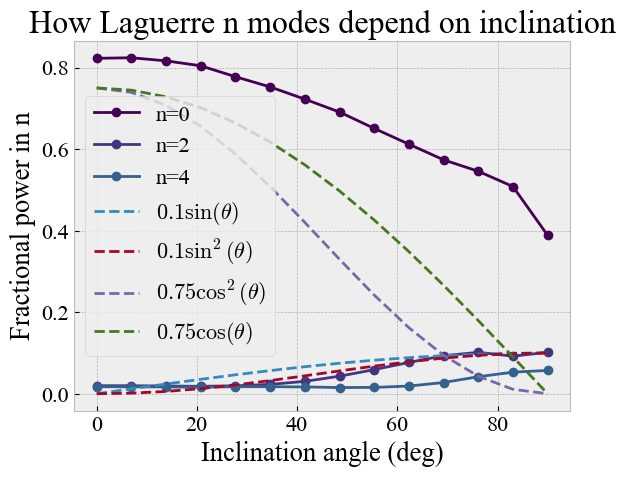

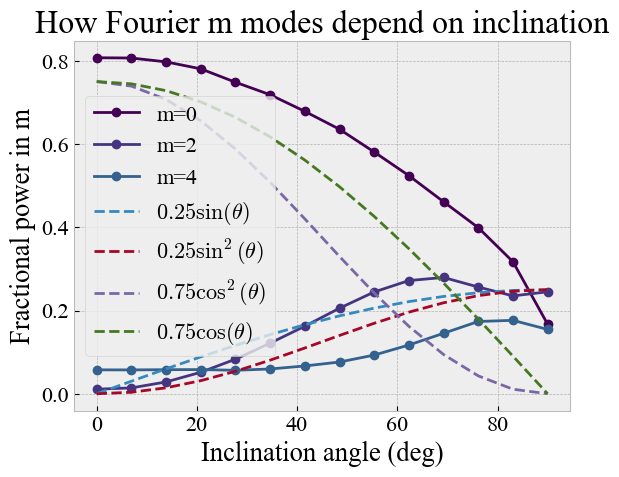

In [ ]:
with h5py.File("example_galaxy.hdf5", "a") as f:
    group = f.require_group("f444w/00001_expansion")
    
    # Remove datasets if they exist
    for dname in ["coscoefs", "sincoefs"]:
        if dname in group:
            del group[dname]
    
    # Saving and grouing coefficients
    group.create_dataset("coscoefs", data=E.coscoefs)
    group.create_dataset("sincoefs", data=E.sincoefs)
    group.attrs["inclination_angle_deg"] = inclinationvalue


#Uncomment to print and check the coefficients
#print(E.coscoefs)
#print(E.sincoefs)

# Parameters
rmax = 8.
nbins = 512
mmax = 10
nmax = 10

# Inclination angles to test, period of 90 degrees, 90 itself results in a fully inclined disc
inclinations = [0, 30, 60, 85]

# Prepare figure and loop through inclinations, storing coefficients results

for idx, inc in enumerate(inclinations):
    # Generate galaxy
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.)
    E = D.make_expansion(mmax, nmax, a)
    
    # Compute magnitude of coefficients
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    
    # Sum over m to get total power per m
    m_power = np.sum(coef_mag, axis=1)
    
    
    n_power = np.sum(coef_mag, axis=0)


rmax = 11.
nbins = 512
mmax = 10
nmax = 10
inclinations = np.linspace(0, 90, 14)  # Inclination angles from 0 to 85 degrees
colormap = plt.cm.viridis(np.linspace(0, 1, len(inclinations)))

# Store results
results = []

for inc in inclinations:
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.)
    E = D.make_expansion(mmax, nmax, a)
    
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_power = np.sum(coef_mag, axis=1)
    n_power = np.sum(coef_mag, axis=0)
    total_n_power = np.sum(n_power)
    total_m_power = np.sum(m_power)
    fracn_power = n_power / total_n_power
    fracm_power = m_power / total_m_power
    
    results.append({
        "inclination": inc,
        "m_power": m_power,
        "n_power": n_power,
        "fracn_power": fracn_power,
        "fracm_power": fracm_power
    })

# Plot fractional power vs inclination for each n (Laguerre mode)
theta_deg = np.array([r["inclination"] for r in results])
theta_rad = np.radians(theta_deg)

for n in range(0,5,2):
    plt.plot(theta_deg,
             [r["fracn_power"][n] for r in results],
             marker='o', label=f"n={n}", color=colormap[n])

# Overplot trigonometric functions
plt.plot(theta_deg, 0.1*np.sin(theta_rad), '--', label=r'$0.1\sin(\theta)$')
plt.plot(theta_deg, 0.1*np.sin(theta_rad)**2, '--', label=r'$0.1\sin^2(\theta)$')
plt.plot(theta_deg, 0.75*np.cos(theta_rad)**2, '--', label=r'$0.75\cos^2(\theta)$')
plt.plot(theta_deg, 0.75*np.cos(theta_rad), '--', label=r'$0.75\cos(\theta)$')

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Fractional power in n")
plt.legend()
plt.title("How Laguerre n modes depend on inclination")
plt.show()

for m in range(0,5,2):
    plt.plot(theta_deg,
             [r["fracm_power"][m] for r in results],
             marker='o', label=f"m={m}", color=colormap[m])

# Overplot trigonometric functions
plt.plot(theta_deg, 0.25*np.sin(theta_rad), '--', label=r'$0.25\sin(\theta)$')
plt.plot(theta_deg, 0.25*np.sin(theta_rad)**2, '--', label=r'$0.25\sin^2(\theta)$')
plt.plot(theta_deg, 0.75*np.cos(theta_rad)**2, '--', label=r'$0.75\cos^2(\theta)$')
plt.plot(theta_deg, 0.75*np.cos(theta_rad), '--', label=r'$0.75\cos(\theta)$')

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Fractional power in m")
plt.legend()
plt.title("How Fourier m modes depend on inclination")
plt.show()

a clear sinusoidal preiodic pattern but requires compressing in x axis, will proceed to find best fit later relative to m,n=0

## Comparing order ratios

Computing expansions: 100%|██████████| 20/20 [00:02<00:00,  7.01it/s]


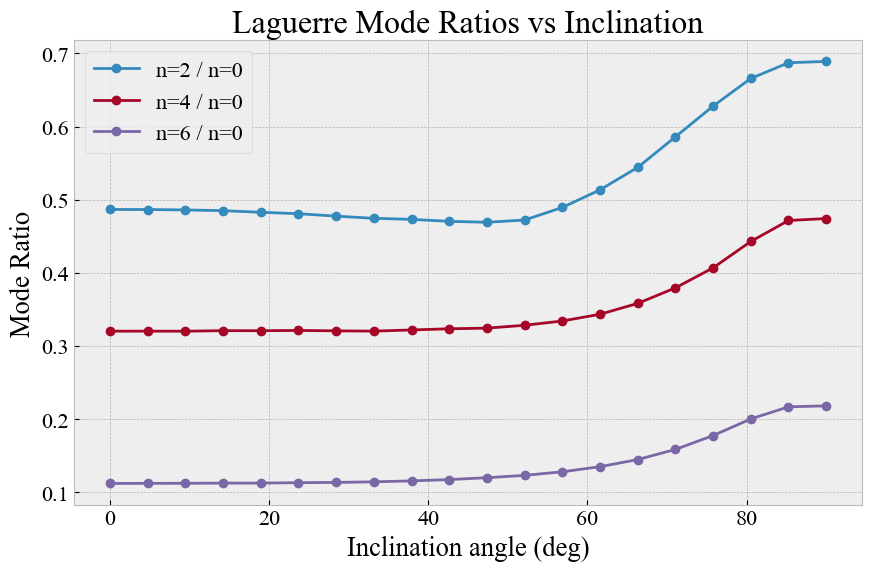

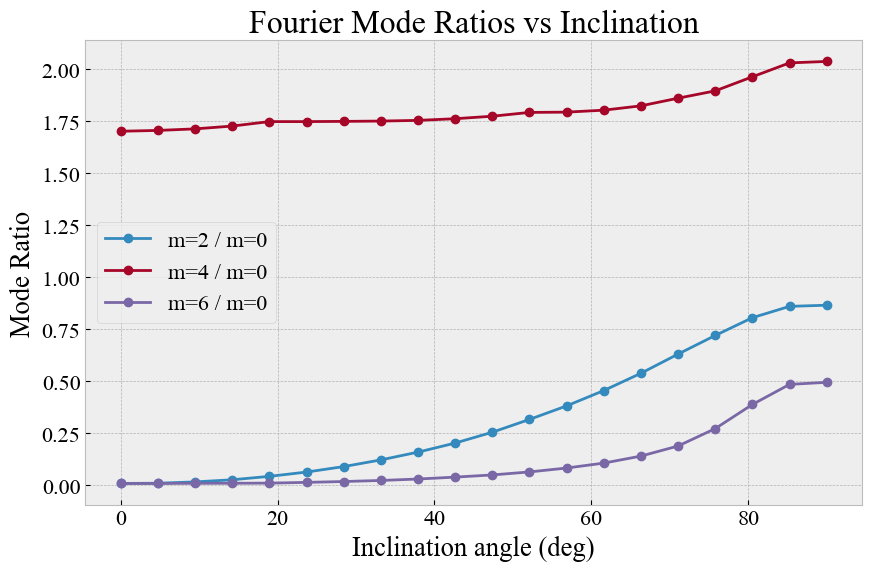

In [5]:
#Parameters
rmax = 20.
nbins = 64
noise = 0.5
mmax = 10
nmax = 10

# Inclination angles to scan
inclinations = np.linspace(0, 90, 20)

# Store results
results = []

#Compute fractional power for each inclination
for inc in tqdm(inclinations, desc="Computing expansions"):
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    E = D.make_expansion(mmax, nmax, a)
    
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_power = np.sum(coef_mag, axis=1)
    n_power = np.sum(coef_mag, axis=0)
    total_n_power = np.sum(n_power)
    total_m_power = np.sum(m_power)
    fracm_power = m_power / total_m_power
    fracn_power = n_power / total_n_power
    
    results.append({
        "inclination": inc,
        "fracn_power": fracn_power,
        "fracm_power": fracm_power,
        "m_power": m_power,
        "n_power": n_power
    })

# Data for ratios
theta_deg = np.array([r["inclination"] for r in results])
Pn0 = np.array([r["fracn_power"][0] for r in results])
Pn2 = np.array([r["fracn_power"][2] for r in results])
Pn4 = np.array([r["fracn_power"][4] for r in results])
Pn6 = np.array([r["fracn_power"][6] for r in results])

Rn2 = Pn2 / Pn0
Rn4 = Pn4 / Pn0
Rn6 = Pn6 / Pn0

theta_rad = np.radians(theta_deg)

plt.figure(figsize=(9, 6))

plt.plot(theta_deg, Rn2, 'o-', label='n=2 / n=0')
plt.plot(theta_deg, Rn4, 'o-', label='n=4 / n=0')
plt.plot(theta_deg, Rn6, 'o-', label='n=6 / n=0')

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Mode Ratio")
plt.title("Laguerre Mode Ratios vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

theta_deg = np.array([r["inclination"] for r in results])
Pm0 = np.array([r["fracm_power"][0] for r in results])
Pm2 = np.array([r["fracm_power"][2] for r in results])
Pm4 = np.array([r["fracm_power"][4] for r in results])
Pm6 = np.array([r["fracm_power"][6] for r in results])

Rm2 = Pm2 / Pm0
Rm4 = Pm4 / Pm0
Rm6 = Pm6 / Pm0

theta_rad = np.radians(theta_deg)

plt.figure(figsize=(9, 6))

plt.plot(theta_deg, Rm2, 'o-', label='m=2 / m=0')
plt.plot(theta_deg, Rm4, 'o-', label='m=4 / m=0')
plt.plot(theta_deg, Rm6, 'o-', label='m=6 / m=0')

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Mode Ratio")
plt.title("Fourier Mode Ratios vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


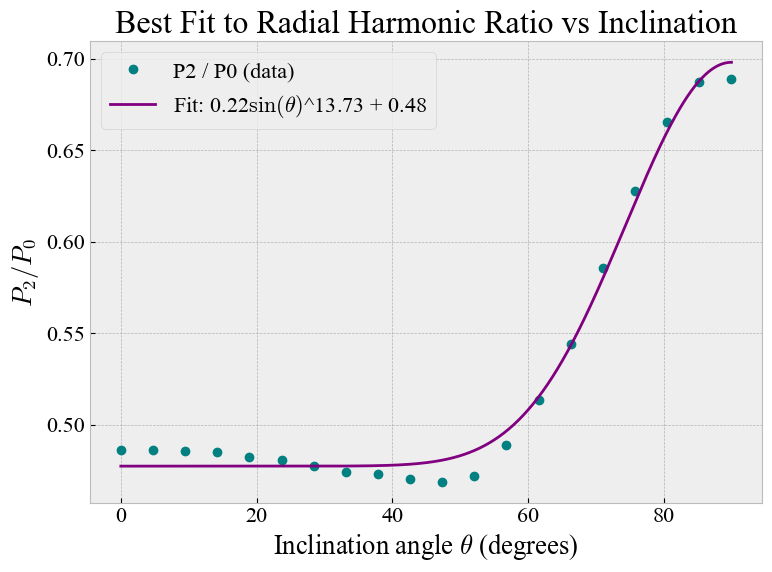

Best fit model:
  R(θ) = 0.221sin(theta)^13.729 + 0.478
RMSE = 0.00708


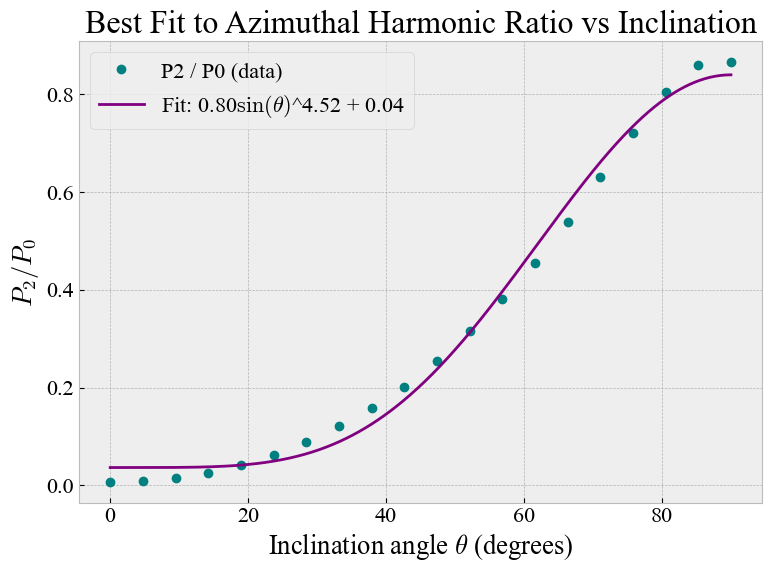

Best fit model:
  R(θ) = 0.803sin(theta)^4.517 + 0.036
RMSE = 0.02439


In [6]:
#Laguerre mode ratios vs inclination
#  Data 
theta_deg = np.array([r["inclination"] for r in results])
Pn0 = np.array([r["fracn_power"][0] for r in results])
Pn2 = np.array([r["fracn_power"][2] for r in results])
Pn4 = np.array([r["fracn_power"][4] for r in results])
Pn6 = np.array([r["fracn_power"][6] for r in results])

Rn2 = Pn2 / Pn0
Rn4 = Pn4 / Pn0
Rn6 = Pn6 / Pn0 # mode ratio

#Fitting model
def model(theta_deg, A, C, D):
    theta_rad = np.radians(theta_deg)
    return A * np.sin(theta_rad)**C + D

# Fit the model
popt, pcov = curve_fit(model, theta_deg, Rn2, p0=[0.5, 2.0, 0.0])
A_fit, C_fit, D_fit = popt

# Evaluate the fit
theta_fit = np.linspace(0, 90, 500)
Rn_fit = model(theta_fit, *popt)

# Compute RMSE
Rn2_pred = model(theta_deg, *popt)
rmse = np.sqrt(np.mean((Rn2 - Rn2_pred)**2))

# Plot 
plt.figure(figsize=(8,6))
plt.plot(theta_deg, Rn2, 'o', label='P2 / P0 (data)', color='teal')
plt.plot(theta_fit, Rn_fit, '-', label=rf'Fit: {A_fit:.2f}$\sin(\theta)$^{C_fit:.2f} + {D_fit:.2f}', color='purple')

plt.xlabel(r"Inclination angle $\theta$ (degrees)")
plt.ylabel(r"$P_2 / P_0$")
plt.title("Best Fit to Radial Harmonic Ratio vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print formula and RMSE
print(f"Best fit model:\n  R(θ) = {A_fit:.3f}sin(theta)^{C_fit:.3f} + {D_fit:.3f}")
print(f"RMSE = {rmse:.5f}")

#Fourier mode ratios vs inclination
#  Data 
theta_deg = np.array([r["inclination"] for r in results])
Pm0 = np.array([r["fracm_power"][0] for r in results])
Pm2 = np.array([r["fracm_power"][2] for r in results])
Pm4 = np.array([r["fracm_power"][4] for r in results])
Pm6 = np.array([r["fracm_power"][6] for r in results])

Rm2 = Pm2 / Pm0
Rm4 = Pm4 / Pm0
Rm6 = Pm6 / Pm0 # mode ratio 
Rm6_4= Pm6 / Pm4  # ratio of m=6 to m=4
Rm4_2= Pm4 / Pm2  # ratio of m=4 to m=2
#Fitting model
def model(theta_deg, A, C, D):
    theta_rad = np.radians(theta_deg)
    return A * np.sin(theta_rad)**C + D

# Fit the model
popt, pcov = curve_fit(model, theta_deg, Rm2, p0=[0.5, 2.0, 0.0])
A_fit, C_fit, D_fit = popt

# Evaluate the fit
theta_fit = np.linspace(0, 90, 500)
Rm_fit = model(theta_fit, *popt)

# Compute RMSE
Rm2_pred = model(theta_deg, *popt)
rmse = np.sqrt(np.mean((Rm2 - Rm2_pred)**2))

# Plot 
plt.figure(figsize=(8,6))
plt.plot(theta_deg, Rm2, 'o', label='P2 / P0 (data)', color='teal')
plt.plot(theta_fit, Rm_fit, '-', label=rf'Fit: {A_fit:.2f}$\sin(\theta)$^{C_fit:.2f} + {D_fit:.2f}', color='purple')

plt.xlabel(r"Inclination angle $\theta$ (degrees)")
plt.ylabel(r"$P_2 / P_0$")
plt.title("Best Fit to Azimuthal Harmonic Ratio vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print formula and RMSE
print(f"Best fit model:\n  R(θ) = {A_fit:.3f}sin(theta)^{C_fit:.3f} + {D_fit:.3f}")
print(f"RMSE = {rmse:.5f}")

dependence only on $\theta$, no additional factor in argument